In [1]:
%%capture
%cd ..

In [2]:
import os
from pathlib import Path
from birds import config
from birds.utils.kaggle import download_dataset

In [3]:
if download_dataset(config.OWNER, config.DATASET, config.DATA_PATH):
    import os
    import tarfile

    with tarfile.open(Path(config.DATA_PATH) / "CUB_200_2011.tgz", "r:gz") as tar:
        tar.extractall(path=config.DATA_PATH)

    os.remove(Path(config.DATA_PATH) / "CUB_200_2011.tgz")
    os.remove(Path(config.DATA_PATH) / "segmentations.tgz")


In [4]:
from fastai.vision.all import *

In [5]:
path = Path(config.DATA_PATH) / "CUB_200_2011"

In [6]:
with open(path / "images.txt", "r") as file:
    lines = [line.strip().split()[1] for line in file.readlines()]
len(lines), lines[15]

(11788, '001.Black_footed_Albatross/Black_Footed_Albatross_0016_796067.jpg')

In [7]:
def get_birds_images(path):
    with open(path / "images.txt", "r") as file:
        lines = [path.resolve() / "images" / line.strip().split()[1] for line in file.readlines()]
    return lines

In [8]:
with open(path / "train_test_split.txt", "r") as file:
    lines = [line.strip() for line in file.readlines()]
len(lines), lines[15]

(11788, '16 0')

In [9]:
def BirdsSplitter(path):
    with open(path / "train_test_split.txt", "r") as file:
        valid_idx = [int(line.strip().split()[0]) - 1 for line in file.readlines() if line.strip().split()[1] == '1']
    return IndexSplitter(valid_idx)

In [10]:
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.0, 1.0))
batch_tfms = [
    *aug_transforms(size=224, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]
bs = 64

In [11]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_birds_images,
    splitter=BirdsSplitter(path),
    get_y=RegexLabeller(pat=r"/([^/]+)_\d+_\d+\.jpg"),
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

## Transformations on validation dataset

Notes:
* split_idx is set in a transform to indicate that only is executed on that split. None value makes transform to execute always, doing different things if split_idx==0 (train) or split_idx==1 (valid).
* RandTransform is only applied to the training set by default (split_idx = 0), unless split_idx is set to None in some child transform.

In [12]:
birds.datasets

<bound method DataBlock.datasets of <fastai.data.block.DataBlock object at 0x7fcc180cab90>>

In [13]:
for tmfs in birds.item_tfms:
    print(tmfs)
    print("---------------")

ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: 
---------------
RandomResizedCrop -- {'size': (460, 460), 'min_scale': 0.75, 'ratio': (1.0, 1.0), 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0}:
encodes: (Image,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: 
---------------


* ToTensor seems to be simple and we can use torch transform
* RandomResizedCrop is a RandTransform, but according to its documentation, on the validation set, we center crop the image if it’s ratio isn’t in the range (to the minmum or maximum value) then resize.

In [14]:
for tmfs in birds.batch_tfms:
    print(tmfs)
    print("---------------")

IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes

---------------
Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: 
---------------
Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: 
---------------
Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> encodes
(Tabular,object) -> encodes
decodes: (TensorImage,object) -> decodes
(Tabular,object) -> decodes

---------------


* IntToFloatTensor seems easy enough and we can probably use the torch version
* Flip and Brightness are RandTransforms and are not applied to validation, but as we are using the size parameter, a RandomResizeCropGPU is done (doing center croping on validation) using the affine matrices.
* Normalize seems easy enough to try replacing it with torch version

In [15]:
dls = birds.dataloaders(path, bs=bs)

In [16]:
for tmfs in dls.valid.after_item:
    print(tmfs)
    print("----------------")

RandomResizedCrop -- {'size': (460, 460), 'min_scale': 0.75, 'ratio': (1.0, 1.0), 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0}:
encodes: (Image,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: 
----------------
ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: 
----------------


In [17]:
for tmfs in dls.valid.after_batch:
    print(tmfs)
    print("----------------")

IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes

----------------
Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: 
----------------
Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: 
----------------
Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}:
encodes: (TensorImage,object) -> encodes
(Tabular,object) -> encodes
decodes: (TensorImage,object) -> decodes
(Tabular,object) -> decodes

----------------


Test to see that aug_transforms actually do something in validation although they are augmentations, due the size parameter

In [18]:
import torch
from fastcore.transform import Pipeline
from fastai.vision.data import TensorImage
from fastai.vision.augment import TensorImage, aug_transforms, Pipeline

tfms = aug_transforms(size=224)

In [19]:
tfms.__repr__()

"[Flip -- {'size': 224, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:\nencodes: (TensorImage,object) -> encodes\n(TensorMask,object) -> encodes\n(TensorBBox,object) -> encodes\n(TensorPoint,object) -> encodes\ndecodes: , Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:\nencodes: (TensorImage,object) -> encodes\ndecodes: ]"

In [20]:
t = TensorImage(torch.rand(3,448,448))
p = Pipeline(tfms)
tfmd_tensor = p(t.unsqueeze(0))
# If nothing happened, this would be false
assert tfmd_tensor.shape == torch.Size([1,3,224,224])

The reason is that AffineCoordTfm transforms uses the affine matrices to perform a GPU crop in validation (https://github.com/fastai/fastai/blob/4d1834cb0b6ac20b068de55cf57f40a0c2296cd4/fastai/vision/augment.py#L491) by using a different matrix for validation. This is equivalent to call RandomResizedCropGPU transform on validation.

## Check RandomResizedCrop behaviour on validation

In [21]:
im = PILImage.create(get_birds_images(path)[50])
im.shape

(500, 500)

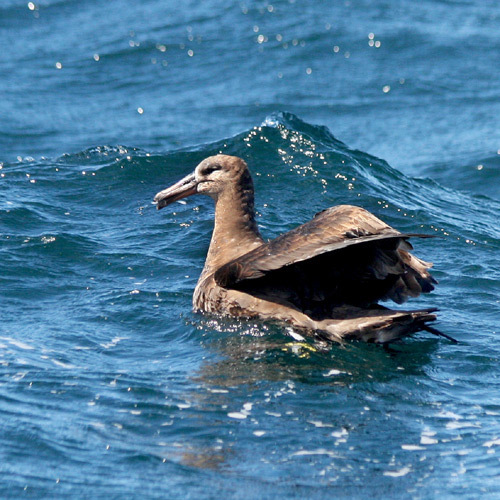

In [22]:
im

In [23]:
import fastai.vision.augment as fastai_aug

In [24]:
crop_fastai = fastai_aug.CropPad((460, 460))
crop_rrc = fastai_aug.RandomResizedCrop((460, 460))

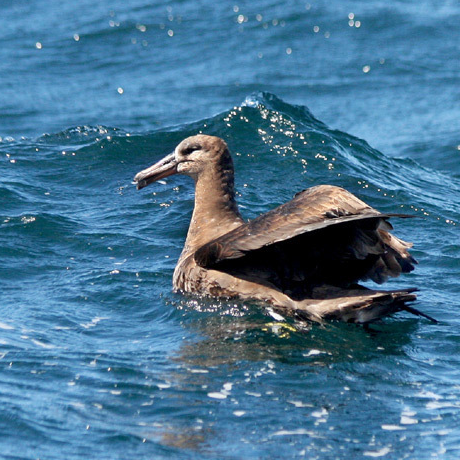

In [25]:
crop_fastai(im, split_idx=1)

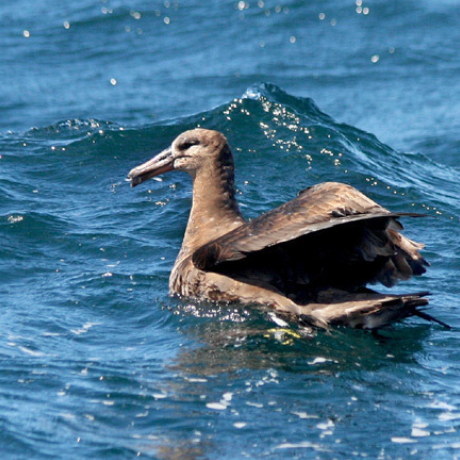

In [26]:
crop_rrc(im, split_idx=1)

In [27]:
%%capture
%cd ..

In [29]:
from deployment.transforms import resized_crop_pad

In [32]:
cropped = resized_crop_pad(im, (460, 460))
cropped.shape

(460, 460)

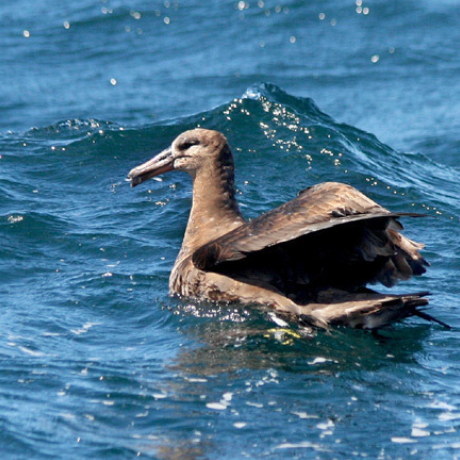

In [33]:
cropped